Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from glob import glob

import warnings
warnings.filterwarnings('ignore')

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/DL_CNN/assignment_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/DL_CNN/assignment_data/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size

)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## for test set , creating only 1 batch
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    batch_size=118,
    image_size=(img_height,img_width)
)

Found 118 files belonging to 9 classes.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
print(len(class_names))



['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


In [10]:
val_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

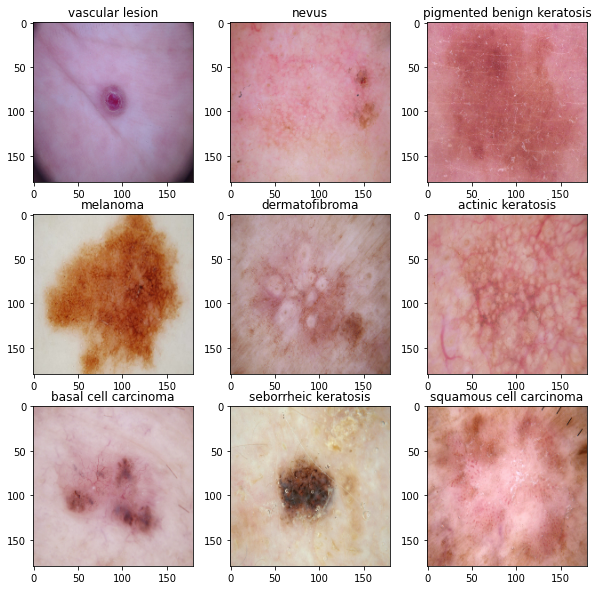

In [11]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plot_idx=0
visited={}
visited_all=False
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(50):
  if not visited_all:
    for i in range(9):
      if len(visited.keys())==9:
        visited_all=True
        break
      if class_names[labels[i]] in visited.keys():
        continue
      else:
        plt.subplot(3,3,plot_idx+1)
        plt.imshow(images[i].numpy().astype("uint8"));
        plt.title(class_names[labels[i]])
        visited[class_names[labels[i]]]="Y"
        plot_idx+=1
  else:
    break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here

num_classes = 9

# https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.25),
                    Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.5),
                    Flatten(),
                    Dense(512,activation='relu'),
                    #Dense(len(class_names))
                    #droput regularisation
                    Dropout(0.5),
                    Dense(num_classes, activation = "softmax")
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 220s 971ms/step - loss: 2.2824 - accuracy: 0.1847 - val_loss: 2.0263 - val_accuracy: 0.2103
Epoch 2/20
56/56 [==============================] - 2s 39ms/step - loss: 1.9556 - accuracy: 0.2790 - val_loss: 1.7739 - val_accuracy: 0.4004
Epoch 3/20
56/56 [==============================] - 2s 39ms/step - loss: 1.8338 - accuracy: 0.3365 - val_loss: 1.6159 - val_accuracy: 0.4183
Epoch 4/20
56/56 [==============================] - 2s 39ms/step - loss: 1.6896 - accuracy: 0.3912 - val_loss: 1.5801 - val_accuracy: 0.4564
Epoch 5/20
56/56 [==============================] - 2s 39ms/step - loss: 1.5591 - accuracy: 0.4615 - val_loss: 1.4392 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 2s 39ms/step - loss: 1.4123 - accuracy: 0.5039 - val_loss: 1.4023 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3538 - accuracy: 0.5212 - val_loss: 1.3643 - val_accuracy: 0.5190
Epoch 8/20

### Visualizing training results

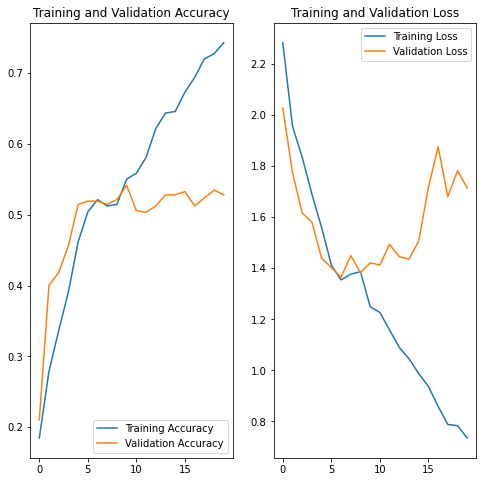

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  y_true=list(labels.numpy())
  y_pred=np.argmax(model.predict(images), axis=-1)
  # break
print(classification_report(y_true,y_pred,target_names=class_names))
print("*"*20)
print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))

                            precision    recall  f1-score   support

         actinic keratosis       0.67      0.12      0.21        16
      basal cell carcinoma       0.27      0.25      0.26        16
            dermatofibroma       0.33      0.06      0.11        16
                  melanoma       0.11      0.12      0.12        16
                     nevus       0.41      0.81      0.54        16
pigmented benign keratosis       0.30      0.75      0.43        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.25      0.06      0.10        16
           vascular lesion       0.67      0.67      0.67         3

                  accuracy                           0.31       118
                 macro avg       0.33      0.32      0.27       118
              weighted avg       0.33      0.31      0.26       118

********************
Accuracy on test dataset :  0.3135593220338983


In [20]:
# lets try the same model with more epochs and different opitmizer

num_classes = 9

model_rmsprop = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.25),
                    Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.5),
                    Flatten(),
                    Dense(512,activation='relu'),
                    #Dense(len(class_names))
                    #droput regularisation
                    Dropout(0.5),
                    Dense(num_classes, activation = "softmax")
])

model_rmsprop.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 30
history_rmsprop = model_rmsprop.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 4s 45ms/step - loss: 2.7049 - accuracy: 0.1892 - val_loss: 2.0315 - val_accuracy: 0.1991
Epoch 2/30
56/56 [==============================] - 2s 42ms/step - loss: 2.0777 - accuracy: 0.2333 - val_loss: 1.9355 - val_accuracy: 0.2953
Epoch 3/30
56/56 [==============================] - 2s 43ms/step - loss: 1.9976 - accuracy: 0.2701 - val_loss: 1.9044 - val_accuracy: 0.3400
Epoch 4/30
56/56 [==============================] - 2s 42ms/step - loss: 1.8391 - accuracy: 0.3616 - val_loss: 1.7804 - val_accuracy: 0.3378
Epoch 5/30
56/56 [==============================] - 2s 42ms/step - loss: 1.7240 - accuracy: 0.3878 - val_loss: 1.6451 - val_accuracy: 0.4094
Epoch 6/30
56/56 [==============================] - 2s 43ms/step - loss: 1.6458 - accuracy: 0.4392 - val_loss: 1.5589 - val_accuracy: 0.4407
Epoch 7/30
56/56 [==============================] - 2s 43ms/step - loss: 1.6704 - accuracy: 0.4280 - val_loss: 1.6550 - val_accuracy: 0.4183
Epoch 8/30
56

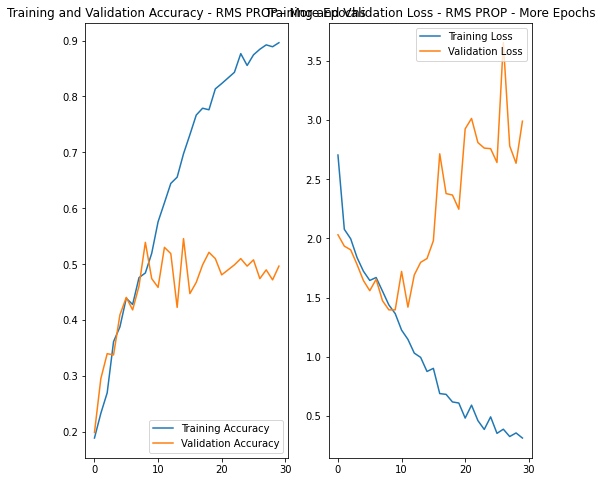

In [21]:
#visualizing results for different model

acc = history_rmsprop.history['accuracy']
val_acc = history_rmsprop.history['val_accuracy']

loss = history_rmsprop.history['loss']
val_loss = history_rmsprop.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - RMS PROP - More Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - RMS PROP - More Epochs')
plt.show()

In [22]:
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  y_true=list(labels.numpy())
  y_pred = np.argmax(model_rmsprop.predict(images), axis=-1)
  # break
print(classification_report(y_true,y_pred,target_names=class_names))
print("*"*20)
print("RMS prop Accuracy on test dataset : ",accuracy_score(y_true,y_pred))

                            precision    recall  f1-score   support

         actinic keratosis       1.00      0.06      0.12        16
      basal cell carcinoma       0.38      0.38      0.38        16
            dermatofibroma       0.33      0.06      0.11        16
                  melanoma       0.07      0.06      0.06        16
                     nevus       0.26      0.69      0.37        16
pigmented benign keratosis       0.38      0.75      0.50        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.40      0.12      0.19        16
           vascular lesion       0.67      0.67      0.67         3

                  accuracy                           0.31       118
                 macro avg       0.39      0.31      0.27       118
              weighted avg       0.40      0.31      0.25       118

********************
RMS prop Accuracy on test dataset :  0.3050847457627119


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
we have trained the same model with different optimizers (adams , rmsprop) and epochs(20 ,30) .As we can see , till 6-7 epochs training and validation accuracy both increase . But after that training accuracy keeps on increasing to 87% whereas validation accuracy keeps fluctuating at 30% . Which means has begun to overfit

In [23]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

In [25]:
from keras.preprocessing.image import ImageDataGenerator

In [26]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)


Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


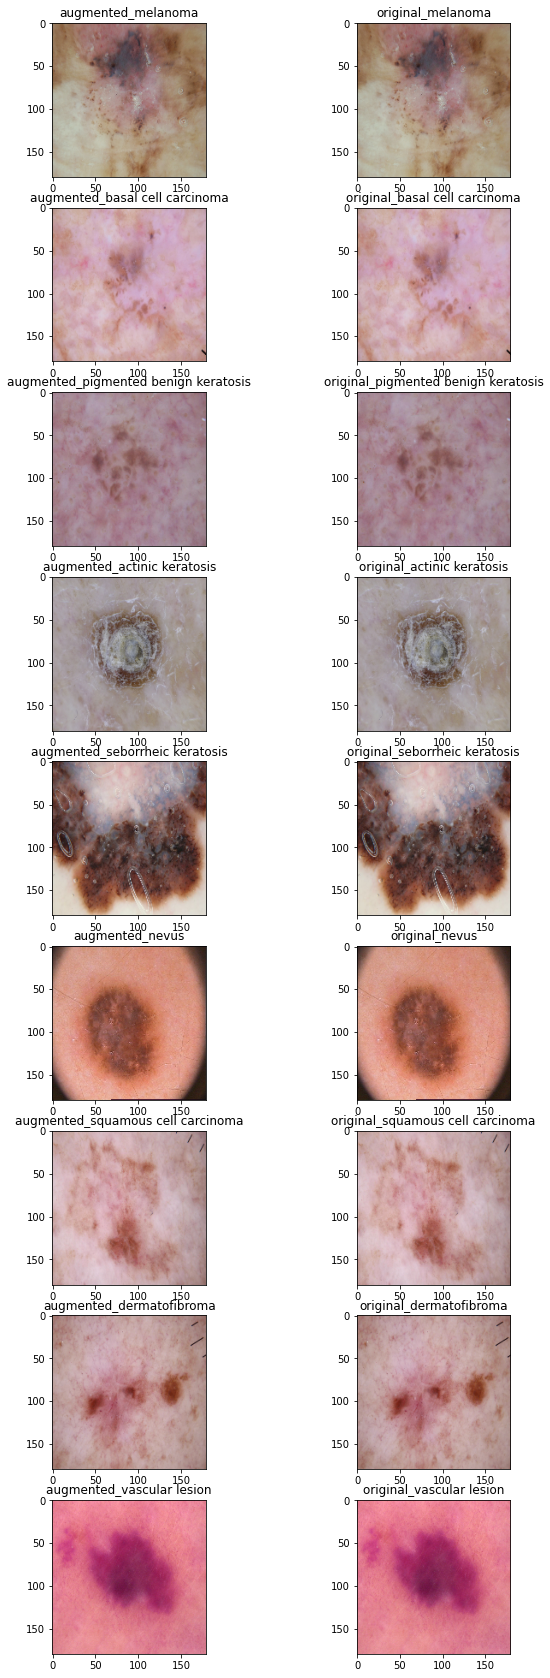

In [28]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plot_idx=0
visited={}
visited_all=False
plt.figure(figsize=(10,30))
for images, labels in train_ds.take(50):
  if not visited_all:
    for i in range(9):
      if len(visited.keys())==9:
        visited_all=True
        break
      if class_names[labels[i]] in visited.keys():
        continue
      else:
        plt.subplot(9,2,plot_idx+1)
        x=data_aug(images)
        plt.imshow(x[i].numpy().astype("uint8"));
        # plt.imshow(images[i].numpy().astype("uint8"));
        plt.title("augmented_"+class_names[labels[i]])
        plot_idx+=1
        plt.subplot(9,2,plot_idx+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("original_"+class_names[labels[i]])
        visited[class_names[labels[i]]]="Y"
        plot_idx+=1
        
  else:
    break


### Todo:
### Create the model, compile and train the model


In [29]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
                    data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.25),
                    Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.5),
                    Flatten(),
                    Dense(512,activation='relu'),
                    #Dense(len(class_names))
                    #droput regularisation
                    Dropout(0.5),
                    Dense(num_classes, activation = "softmax")
])

### Compiling the model

In [30]:
## Your code goes here
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 64)        18496     
                                                      

### Training the model

In [31]:
## Your code goes here, note: train your model for 20 epochs
#history = ## your training code
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 45ms/step - loss: 2.1109 - accuracy: 0.2600 - val_loss: 1.8054 - val_accuracy: 0.3826
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 1.7028 - accuracy: 0.3767 - val_loss: 1.6804 - val_accuracy: 0.3803
Epoch 3/20
56/56 [==============================] - 2s 43ms/step - loss: 1.6913 - accuracy: 0.3783 - val_loss: 1.7372 - val_accuracy: 0.3870
Epoch 4/20
56/56 [==============================] - 2s 43ms/step - loss: 1.6706 - accuracy: 0.3906 - val_loss: 1.5731 - val_accuracy: 0.4564
Epoch 5/20
56/56 [==============================] - 2s 42ms/step - loss: 1.6441 - accuracy: 0.4152 - val_loss: 1.5645 - val_accuracy: 0.4653
Epoch 6/20
56/56 [==============================] - 2s 42ms/step - loss: 1.5640 - accuracy: 0.4542 - val_loss: 1.5432 - val_accuracy: 0.4586
Epoch 7/20
56/56 [==============================] - 2s 43ms/step - loss: 1.5089 - accuracy: 0.4794 - val_loss: 1.4651 - val_accuracy: 0.4765
Epoch 8/20
56

### Visualizing the results

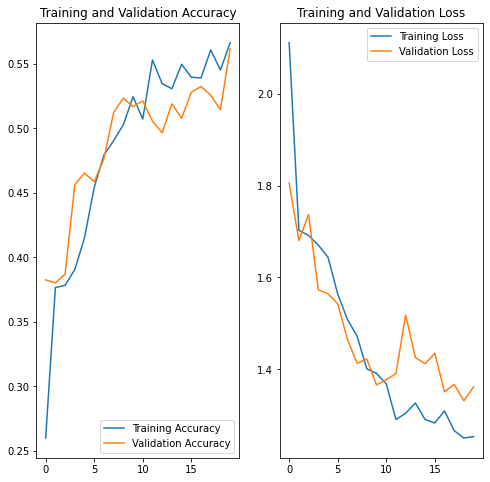

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
# try with different optimizer
model_aug_adagrad = Sequential([
                    data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.25),
                    Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.5),
                    Flatten(),
                    Dense(512,activation='relu'),
                    #Dense(len(class_names))
                    #droput regularisation
                    Dropout(0.5),
                    Dense(num_classes, activation = "softmax")
])

model_aug_adagrad.compile(optimizer='adagrad',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 25
history_aug_adagrad = model_aug_adagrad.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 3s 44ms/step - loss: 2.0660 - accuracy: 0.1948 - val_loss: 2.0300 - val_accuracy: 0.1924
Epoch 2/25
56/56 [==============================] - 2s 42ms/step - loss: 2.0341 - accuracy: 0.1987 - val_loss: 2.0292 - val_accuracy: 0.2148
Epoch 3/25
56/56 [==============================] - 2s 42ms/step - loss: 2.0308 - accuracy: 0.2137 - val_loss: 2.0236 - val_accuracy: 0.1969
Epoch 4/25
56/56 [==============================] - 2s 42ms/step - loss: 2.0330 - accuracy: 0.2009 - val_loss: 2.0189 - val_accuracy: 0.3087
Epoch 5/25
56/56 [==============================] - 2s 42ms/step - loss: 2.0278 - accuracy: 0.2015 - val_loss: 2.0162 - val_accuracy: 0.1924
Epoch 6/25
56/56 [==============================] - 2s 42ms/step - loss: 2.0275 - accuracy: 0.2054 - val_loss: 2.0140 - val_accuracy: 0.2640
Epoch 7/25
56/56 [==============================] - 2s 42ms/step - loss: 2.0243 - accuracy: 0.2165 - val_loss: 2.0147 - val_accuracy: 0.2573
Epoch 8/25
56

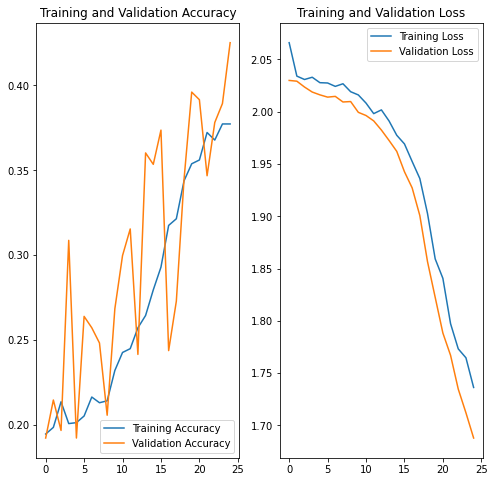

In [34]:
# creating a performance visualisation for adagrad optimiser
acc = history_aug_adagrad.history['accuracy']
val_acc = history_aug_adagrad.history['val_accuracy']

loss = history_aug_adagrad.history['loss']
val_loss = history_aug_adagrad.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
# creating another model with SGD opitmizer
model_aug_sgd = Sequential([
                    data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.25),
                    Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.5),
                    Flatten(),
                    Dense(512,activation='relu'),
                    #Dense(len(class_names))
                    #droput regularisation
                    Dropout(0.5),
                    Dense(num_classes, activation = "softmax")
])

model_aug_sgd.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 25
history_aug_sgd = model_aug_sgd.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 3s 44ms/step - loss: 2.0587 - accuracy: 0.1975 - val_loss: 2.0228 - val_accuracy: 0.2058
Epoch 2/25
56/56 [==============================] - 2s 41ms/step - loss: 2.0377 - accuracy: 0.1897 - val_loss: 2.0135 - val_accuracy: 0.2125
Epoch 3/25
56/56 [==============================] - 2s 41ms/step - loss: 2.0297 - accuracy: 0.2115 - val_loss: 2.0136 - val_accuracy: 0.2394
Epoch 4/25
56/56 [==============================] - 2s 41ms/step - loss: 2.0160 - accuracy: 0.2467 - val_loss: 1.9768 - val_accuracy: 0.3154
Epoch 5/25
56/56 [==============================] - 2s 41ms/step - loss: 1.9966 - accuracy: 0.2612 - val_loss: 1.9718 - val_accuracy: 0.3199
Epoch 6/25
56/56 [==============================] - 2s 41ms/step - loss: 1.9844 - accuracy: 0.2600 - val_loss: 1.9003 - val_accuracy: 0.3468
Epoch 7/25
56/56 [==============================] - 2s 41ms/step - loss: 1.9864 - accuracy: 0.2427 - val_loss: 2.0203 - val_accuracy: 0.2058
Epoch 8/25
56

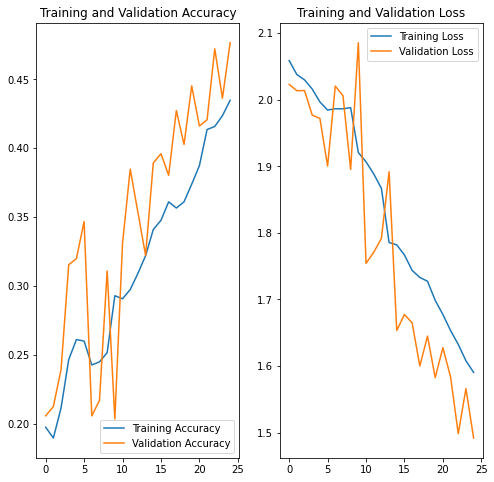

In [36]:
# creating performance visualisation for sgd optimizer
acc = history_aug_sgd.history['accuracy']
val_acc = history_aug_sgd.history['val_accuracy']

loss = history_aug_sgd.history['loss']
val_loss = history_aug_sgd.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
#checking the performance on the test set 
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  # print(model.predict_classes(images))
  # print(labels.numpy())
  y_true=list(labels.numpy())
  y_pred=np.argmax(model.predict(images), axis=1)
  # break
  print("Adam optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)
  y_pred=np.argmax(model_aug_adagrad.predict(images), axis=-1)
  # break
  print("Adagrad optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)
  y_pred= np.argmax(model_aug_adagrad.predict(images), axis=-1)
  # break
  print("SGD optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)

Adam optimizer
                            precision    recall  f1-score   support

         actinic keratosis       1.00      0.06      0.12        16
      basal cell carcinoma       0.37      0.62      0.47        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.12      0.12      0.12        16
                     nevus       0.42      0.88      0.57        16
pigmented benign keratosis       0.34      0.75      0.47        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.67      0.12      0.21        16
           vascular lesion       1.00      0.67      0.80         3

                  accuracy                           0.36       118
                 macro avg       0.44      0.36      0.31       118
              weighted avg       0.42      0.36      0.29       118

Accuracy on test dataset :  0.3644067796610169
********************
Adagrad optimizer
            

In [38]:
train_path_list = list(data_dir_train.glob('*/*.jpg'))

In [39]:
df=pd.DataFrame({"cancer_type":[str(x).split("/")[2] for x in train_path_list]})

<Figure size 720x720 with 0 Axes>

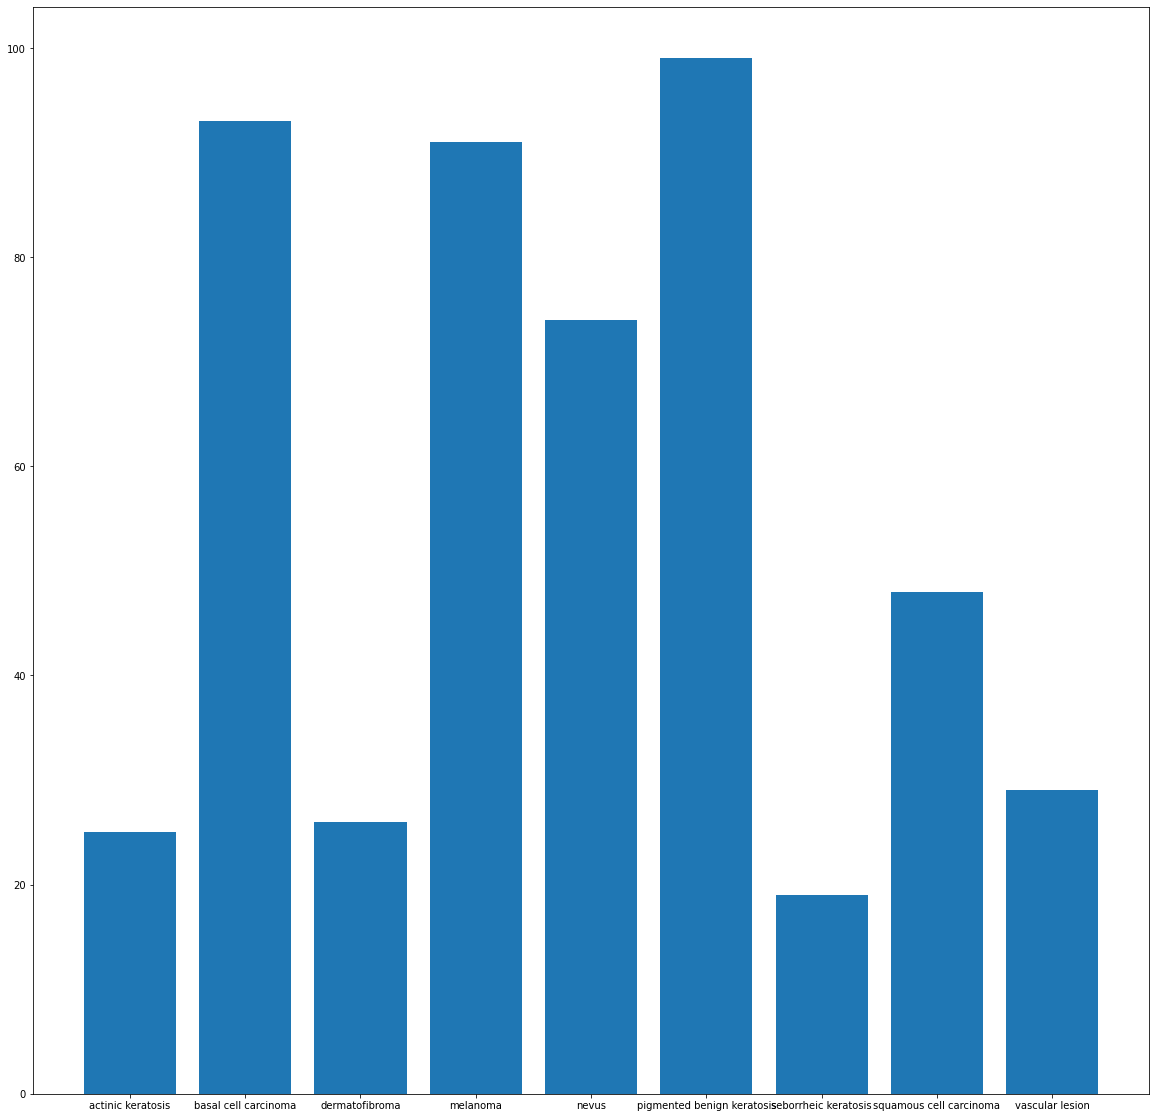

In [40]:
#df['cancer_type'].value_counts().plot(kind='bar')
#plt.title("Distribution of classes")
#plt.show()
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Findings:-> We can see that after addition of Agumentation layers we were able to reduce the model's overfitting . However in this case the model is not able to generalise well . We tried out different set of optmizers sgd , adagrad , adams which gave models that had low Training and Validation accuracy. The accuracy figures were between 45-55% both for training and validation . But now the model has begun to overfit.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
Ans: as per above graph seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
Ans: Pigmented benign keratosis dominates the data of count more than 100 in training


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [41]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [43]:
path_to_training_dataset="/content/gdrive/MyDrive/DL_CNN/assignment_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/DL_CNN/assignment_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F05AC2B0890>: 100%|██████████| 500/500 [00:09<00:00, 52.37 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/DL_CNN/assignment_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F05ABBC1610>: 100%|██████████| 500/500 [00:09<00:00, 51.31 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/DL_CNN/assignment_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F05C61F7C90>: 100%|██████████| 500/500 [00:09<00:00, 52.24 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/DL_CNN/assignment_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F05AC1AB810>: 100%|██████████| 500/500 [00:48<00:00, 10.24 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/DL_CNN/assignment_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=966x645 at 0x7F05AF392950>: 100%|██████████| 500/500 [00:42<00:00, 11.65 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/DL_CNN/assignment_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F05AF2DBB10>: 100%|██████████| 500/500 [00:09<00:00, 52.56 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/DL_CNN/assignment_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F05AC167E10>: 100%|██████████| 500/500 [00:21<00:00, 22.79 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/DL_CNN/assignment_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F05AF30D090>: 100%|██████████| 500/500 [00:09<00:00, 50.57 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/DL_CNN/assignment_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F05AC0CC210>: 100%|██████████| 500/500 [00:09<00:00, 50.73 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [44]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [45]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/DL_CNN/assignment_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032154.jpg_5a5c9040-99eb-4bb6-824c-2f572acb2a08.jpg',
 '/content/gdrive/MyDrive/DL_CNN/assignment_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031191.jpg_696a65ce-5c7a-48ef-91b0-b235b94c82a4.jpg',
 '/content/gdrive/MyDrive/DL_CNN/assignment_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026100.jpg_61bb005c-7aa7-43bb-b5ba-cc006d56e78a.jpg',
 '/content/gdrive/MyDrive/DL_CNN/assignment_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030714.jpg_438cf0f1-edd3-4e71-9e55-46847b40105f.jpg',
 '/content/gdrive/MyDrive/DL_CNN/ass

In [46]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [47]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [48]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [49]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [50]:
df2['Label'].value_counts()

squamous cell carcinoma       1000
vascular lesion               1000
pigmented benign keratosis    1000
melanoma                      1000
dermatofibroma                1000
seborrheic keratosis          1000
basal cell carcinoma          1000
nevus                         1000
actinic keratosis             1000
Name: Label, dtype: int64

In [51]:
#new counts
new_list=list(df['cancer_type'].values)
new_list.extend(list(df2['Label'].values))
len(new_list)
final_df=pd.DataFrame({"cancer_type":new_list})
final_df['cancer_type'].value_counts()

gdrive                        2239
squamous cell carcinoma       1000
vascular lesion               1000
pigmented benign keratosis    1000
melanoma                      1000
dermatofibroma                1000
seborrheic keratosis          1000
basal cell carcinoma          1000
nevus                         1000
actinic keratosis             1000
Name: cancer_type, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [52]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [53]:
data_dir_train="/content/gdrive/MyDrive/DL_CNN/assignment_data/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [54]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [55]:
## your code goes here
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.25),
                    Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.5),
                    Flatten(),
                    Dense(512,activation='relu'),
                    #Dense(len(class_names))
                    #droput regularisation
                    Dropout(0.5),
                    Dense(num_classes, activation = "softmax")
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [56]:
## your code goes here
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                 

#### **Todo:**  Train your model

In [57]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 29s 100ms/step - loss: 1.8434 - accuracy: 0.2760 - val_loss: 1.5594 - val_accuracy: 0.3921
Epoch 2/30
281/281 [==============================] - 29s 100ms/step - loss: 1.5349 - accuracy: 0.4018 - val_loss: 1.3832 - val_accuracy: 0.4642
Epoch 3/30
281/281 [==============================] - 29s 100ms/step - loss: 1.3440 - accuracy: 0.4900 - val_loss: 1.1518 - val_accuracy: 0.5754
Epoch 4/30
281/281 [==============================] - 29s 101ms/step - loss: 1.1363 - accuracy: 0.5712 - val_loss: 1.0620 - val_accuracy: 0.6066
Epoch 5/30
281/281 [==============================] - 29s 100ms/step - loss: 0.9643 - accuracy: 0.6385 - val_loss: 0.8579 - val_accuracy: 0.6725
Epoch 6/30
281/281 [==============================] - 29s 100ms/step - loss: 0.7880 - accuracy: 0.7109 - val_loss: 0.7255 - val_accuracy: 0.7463
Epoch 7/30
281/281 [==============================] - 29s 100ms/step - loss: 0.6134 - accuracy: 0.7768 - val_loss: 0.6516 - val_ac

#### **Todo:**  Visualize the model results

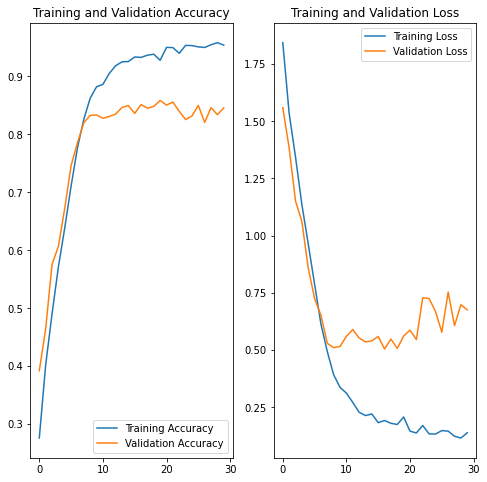

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [59]:
#trying with a different model optimizer 
model_imbalance_sgd = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.25),
                    Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.5),
                    Flatten(),
                    Dense(512,activation='relu'),
                    #Dense(len(class_names))
                    #droput regularisation
                    Dropout(0.5),
                    Dense(num_classes, activation = "softmax")
])

model_imbalance_sgd.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 30
## Your code goes here, use 50 epochs.
history_imbalance_sgd = model_imbalance_sgd.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 30s 105ms/step - loss: 2.1548 - accuracy: 0.1619 - val_loss: 2.1326 - val_accuracy: 0.1611
Epoch 2/30
281/281 [==============================] - 29s 98ms/step - loss: 2.0437 - accuracy: 0.2180 - val_loss: 1.9206 - val_accuracy: 0.3066
Epoch 3/30
281/281 [==============================] - 28s 98ms/step - loss: 1.9254 - accuracy: 0.2542 - val_loss: 2.1600 - val_accuracy: 0.2434
Epoch 4/30
281/281 [==============================] - 28s 98ms/step - loss: 1.8207 - accuracy: 0.3094 - val_loss: 1.6057 - val_accuracy: 0.3961
Epoch 5/30
281/281 [==============================] - 28s 98ms/step - loss: 1.6593 - accuracy: 0.3750 - val_loss: 1.4943 - val_accuracy: 0.4308
Epoch 6/30
281/281 [==============================] - 29s 99ms/step - loss: 1.5458 - accuracy: 0.4248 - val_loss: 1.3383 - val_accuracy: 0.5069
Epoch 7/30
281/281 [==============================] - 28s 99ms/step - loss: 1.4399 - accuracy: 0.4733 - val_loss: 1.2676 - val_accuracy

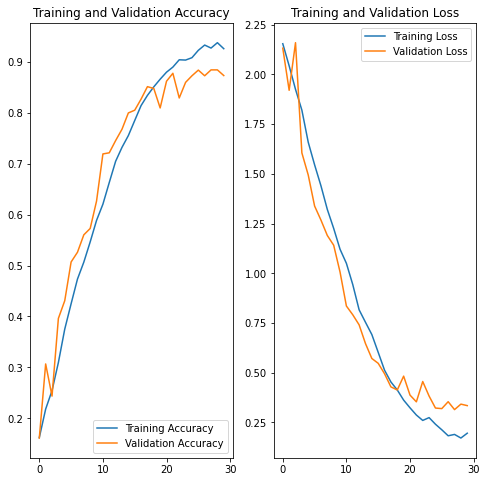

In [60]:
# plot for SGD optimizer
acc = history_imbalance_sgd.history['accuracy']
val_acc = history_imbalance_sgd.history['val_accuracy']

loss = history_imbalance_sgd.history['loss']
val_loss = history_imbalance_sgd.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
#trying with a different model 
model_imbalance_adagrad = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.25),
                    Conv2D(128, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    #Dropout(0.5),
                    Flatten(),
                    Dense(512,activation='relu'),
                    #Dense(len(class_names))
                    #droput regularisation
                    Dropout(0.5),
                    Dense(num_classes, activation = "softmax")
])

model_imbalance_adagrad.compile(optimizer='adagrad',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 30
## Your code goes here, use 50 epochs.
history_imbalance_adagrad = model_imbalance_adagrad.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 29s 99ms/step - loss: 2.1901 - accuracy: 0.1371 - val_loss: 2.1758 - val_accuracy: 0.1500
Epoch 2/30
281/281 [==============================] - 28s 98ms/step - loss: 2.1632 - accuracy: 0.1677 - val_loss: 2.1332 - val_accuracy: 0.2692
Epoch 3/30
281/281 [==============================] - 28s 98ms/step - loss: 2.0653 - accuracy: 0.2211 - val_loss: 1.9375 - val_accuracy: 0.2968
Epoch 4/30
281/281 [==============================] - 28s 99ms/step - loss: 1.8888 - accuracy: 0.2625 - val_loss: 1.7926 - val_accuracy: 0.3382
Epoch 5/30
281/281 [==============================] - 28s 98ms/step - loss: 1.7860 - accuracy: 0.3056 - val_loss: 1.7150 - val_accuracy: 0.3587
Epoch 6/30
281/281 [==============================] - 28s 99ms/step - loss: 1.7325 - accuracy: 0.3237 - val_loss: 1.7080 - val_accuracy: 0.3369
Epoch 7/30
281/281 [==============================] - 28s 99ms/step - loss: 1.6872 - accuracy: 0.3532 - val_loss: 1.6486 - val_accuracy:

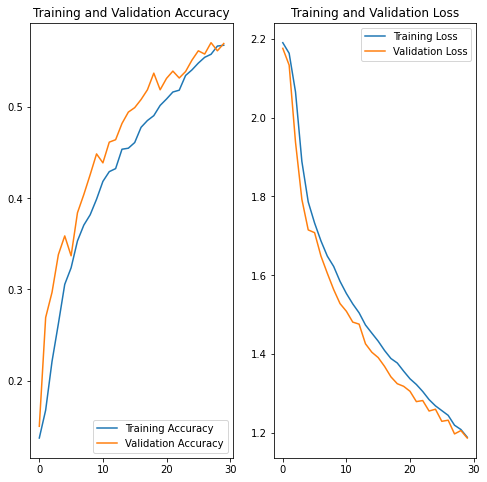

In [62]:
#visualizing for adagrad
acc = history_imbalance_adagrad.history['accuracy']
val_acc = history_imbalance_adagrad.history['val_accuracy']

loss = history_imbalance_adagrad.history['loss']
val_loss = history_imbalance_adagrad.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [63]:
#checking the performance on the test set 
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  # print(model.predict_classes(images))
  # print(labels.numpy())
  y_true=list(labels.numpy())
  y_pred=np.argmax(model.predict(images), axis=-1)
  # break
  print("Adam optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)
  y_pred= np.argmax(model_imbalance_adagrad.predict(images), axis=-1)
  # break
  print("Adagrad optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)
  y_pred=np.argmax(model_imbalance_sgd.predict(images), axis=-1)
  # break
  print("SGD optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)

Adam optimizer
                            precision    recall  f1-score   support

         actinic keratosis       0.14      0.06      0.09        16
      basal cell carcinoma       0.64      0.44      0.52        16
            dermatofibroma       0.44      0.25      0.32        16
                  melanoma       0.10      0.06      0.08        16
                     nevus       0.20      0.56      0.29        16
pigmented benign keratosis       0.42      0.62      0.50        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.50      0.25      0.33        16
           vascular lesion       0.67      0.67      0.67         3

                  accuracy                           0.32       118
                 macro avg       0.34      0.32      0.31       118
              weighted avg       0.35      0.32      0.31       118

Accuracy on test dataset :  0.3220338983050847
********************
Adagrad optimizer
            

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

We tried different models with optimizers (sgd, adams, adagrad) and epochs (30,50,30) . By adding augmented images which inturn helped in handling class imbalance , we mitigated/addressed the problem of overfitting . Out of all the models the performance was decent for the model with Adam's optimizer . The model had a train accuracy of ~93% while the validation accuracy was about ~84% . This model learns rapidly (increase in training and validation accuracy)for the first 20 epochs , but after this the learning becomes slow 

